In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
BATCH_SIZE = 256
EPOCHS = 50
NOISE_DIM = 100
NUM_CLASSES = 10
LR_G = 2e-4
LR_D = 2e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(NOISE_DIM + NUM_CLASSES, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        x = torch.cat([noise, labels], dim=1)
        return self.net(x)


In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784 + NUM_CLASSES, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1)  # logits
        )

    def forward(self, images, labels):
        x = torch.cat([images, labels], dim=1)
        return self.net(x)


In [7]:
G = Generator().to(DEVICE)
D = Discriminator().to(DEVICE)

criterion = nn.BCEWithLogitsLoss()

opt_G = optim.Adam(G.parameters(), lr=LR_G, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=LR_D, betas=(0.5, 0.999))


In [8]:
def one_hot(labels, num_classes):
    return torch.eye(num_classes)[labels].to(DEVICE)


In [9]:
for epoch in range(EPOCHS):
    for real_imgs, labels in dataloader:
        real_imgs = real_imgs.view(BATCH_SIZE, -1).to(DEVICE)
        labels_onehot = one_hot(labels, NUM_CLASSES)

        # =====================
        # Train Discriminator
        # =====================
        # Generate fake images
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, device=DEVICE)
        fake_imgs = G(noise, labels_onehot)

        # Discriminator outputs
        real_logits = D(real_imgs, labels_onehot)
        fake_logits = D(fake_imgs.detach(), labels_onehot)

        # Loss with label smoothing
        real_targets = torch.ones_like(real_logits) * 0.9
        fake_targets = torch.zeros_like(fake_logits)

        loss_D_real = criterion(real_logits, real_targets)
        loss_D_fake = criterion(fake_logits, fake_targets)
        loss_D = loss_D_real + loss_D_fake

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # =====================
        # Train Generator
        # =====================
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, device=DEVICE)
        fake_imgs = G(noise, labels_onehot)
        fake_logits = D(fake_imgs, labels_onehot)
        loss_G = criterion(fake_logits, torch.ones_like(fake_logits))

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch [{epoch+1}/{EPOCHS}] | "
            f"G Loss: {loss_G.item():.4f} | "
            f"D Loss: {loss_D.item():.4f}"
        )

Epoch [5/50] | G Loss: 0.8950 | D Loss: 1.2189
Epoch [10/50] | G Loss: 0.9002 | D Loss: 1.3073
Epoch [15/50] | G Loss: 0.8260 | D Loss: 1.3240
Epoch [20/50] | G Loss: 0.8176 | D Loss: 1.3588
Epoch [25/50] | G Loss: 0.9270 | D Loss: 1.3613
Epoch [30/50] | G Loss: 0.8642 | D Loss: 1.3725
Epoch [35/50] | G Loss: 0.7759 | D Loss: 1.3750
Epoch [40/50] | G Loss: 0.8301 | D Loss: 1.3644
Epoch [45/50] | G Loss: 0.7836 | D Loss: 1.3755
Epoch [50/50] | G Loss: 0.8080 | D Loss: 1.3739


In [14]:
torch.save({
    "generator": G.state_dict(),
    "discriminator": D.state_dict()
}, "gan_checkpoint.pth")


In [15]:
def generate_digit(digit, n=16):
    G.eval()
    noise = torch.randn(n, NOISE_DIM, device=DEVICE)
    labels = one_hot(torch.tensor([digit]*n), NUM_CLASSES)

    with torch.no_grad():
        imgs = G(noise, labels).cpu().view(n, 28, 28)
        # Denormalize from [-1, 1] to [0, 1]
        imgs = (imgs + 1) / 2

    plt.figure(figsize=(4, 4))
    for i in range(n):
        plt.subplot(4, 4, i+1)
        plt.imshow(imgs[i], cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Generated Digit: {digit}")
    plt.tight_layout()
    plt.show()

    G.train()

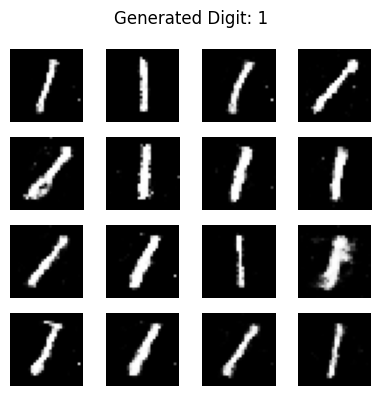

In [17]:
generate_digit(1)
